In [2]:
import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns

from udonpred_benchmarking.constants import DATA_DIR, PLOT_DIR
from udonpred_benchmarking.plots import BARPLOT_KEYWORDS, FIGURE_KEYWORDS, QUARTILE_LABELS, set_theme

In [3]:
residue_df = pl.read_csv(DATA_DIR / "per_residue_predictions.csv")
protein_df = pl.read_csv(DATA_DIR / "per_protein_performance.csv")
protein_stats = pl.read_csv(DATA_DIR / "per_protein_stats.csv")

set_theme()

### G-score distribution

Text(0.5, 1.0, 'Average G-score distribution by protein')

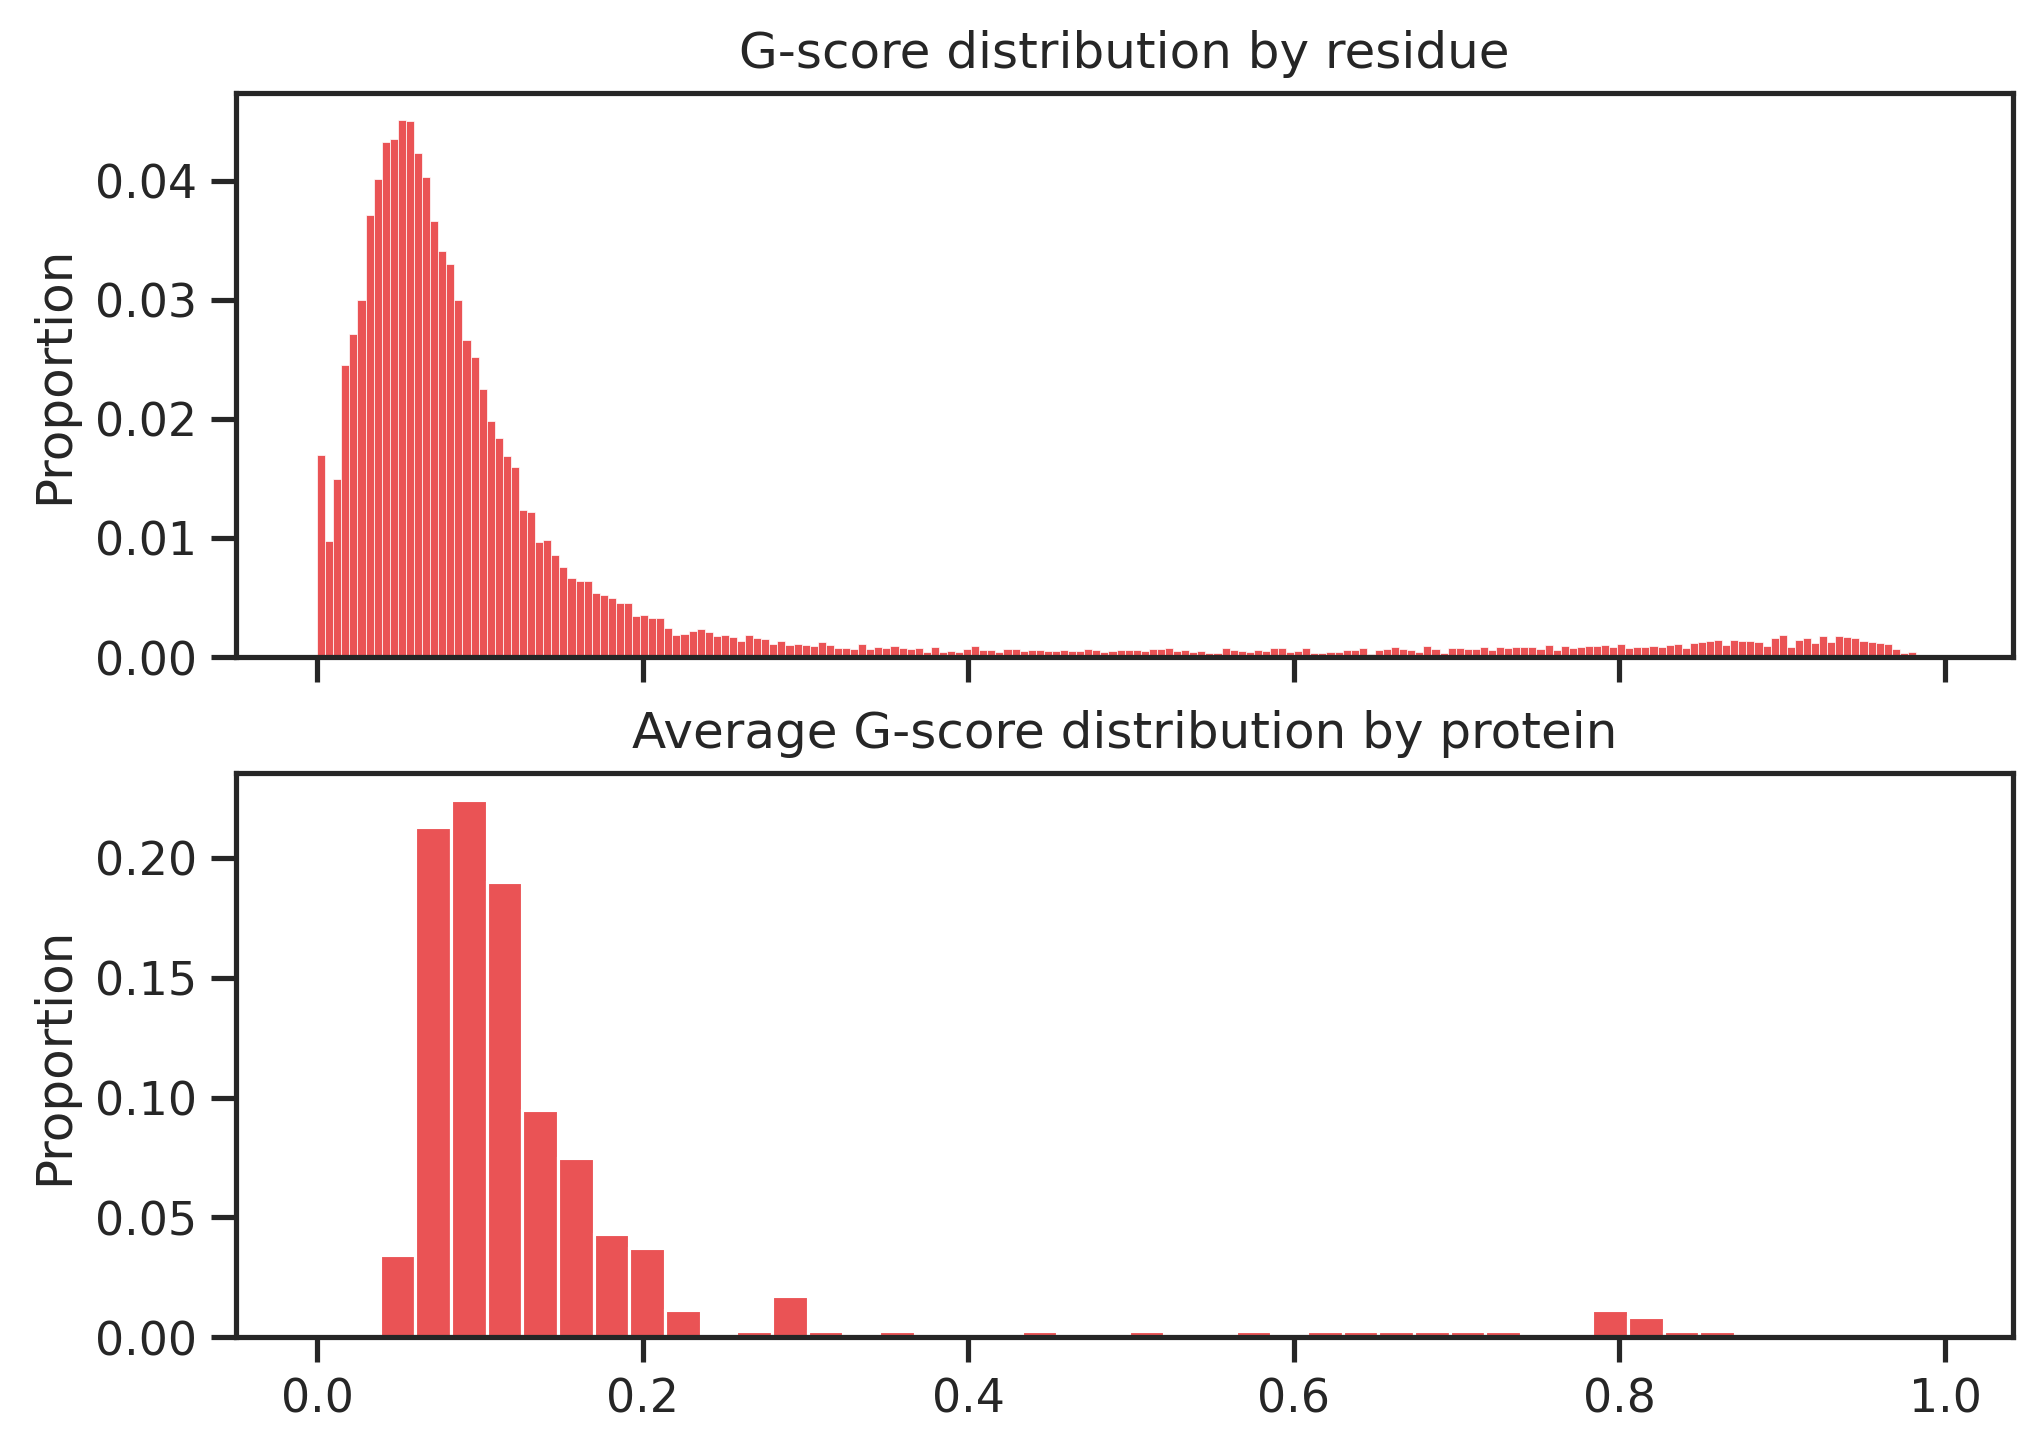

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 1, **FIGURE_KEYWORDS, sharex=True)
sns.histplot(residue_df["pscores"], ax=ax1, stat="proportion")
ax1.set_title("G-score distribution by residue")
sns.histplot(residue_df.group_by("ID").mean()["pscores"], ax=ax2, stat="proportion")
ax2.set_title("Average G-score distribution by protein")

### Stratified by bucket

In [ ]:

def annotate_facetplot(data, **kws):
    n = len(data)
    ax = plt.gca()
    ax.text(.1, .8, f"N = {n}", transform=ax.transAxes)

fig = plt.Figure(**FIGURE_KEYWORDS)
g = sns.FacetGrid(
    protein_df.join(protein_stats, on="ID"),
    col="pscore_mean_category_thirds",
    col_order=["[0, .33)", "[.33, .67]", "(.67, 1]"],
    row="metric",
    hue="method",
    margin_titles=True
)

g.map(sns.barplot, "method", "value", **BARPLOT_KEYWORDS)

g.set_titles(col_template="Gscore ∈ {col_name}", row_template="")
g.set_axis_labels("", "Value")
g.set(ylim=(-.3, 1), xticks=[])
g.map_dataframe(annotate_facetplot)

for _, ax in g.axes_dict.items():
    ax.spines["bottom"].set_position("zero")

g.axes[0, 0].set_ylabel("Spearman ρ")
g.axes[1, 0].set_ylabel("RMSE")
g.axes[2, 0].set_ylabel("APS")
g.add_legend(title="Method")
plt.suptitle("Performance vs. Protein Average Gscore: Buckets", fontsize="x-large")
g.figure.subplots_adjust(top=.85)
plt.savefig(PLOT_DIR / "barplot_by_gscore_bin.png")

### Stratified by quartile

/home/julius/projects/University/Publications/UdonPred/Benchmarking/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


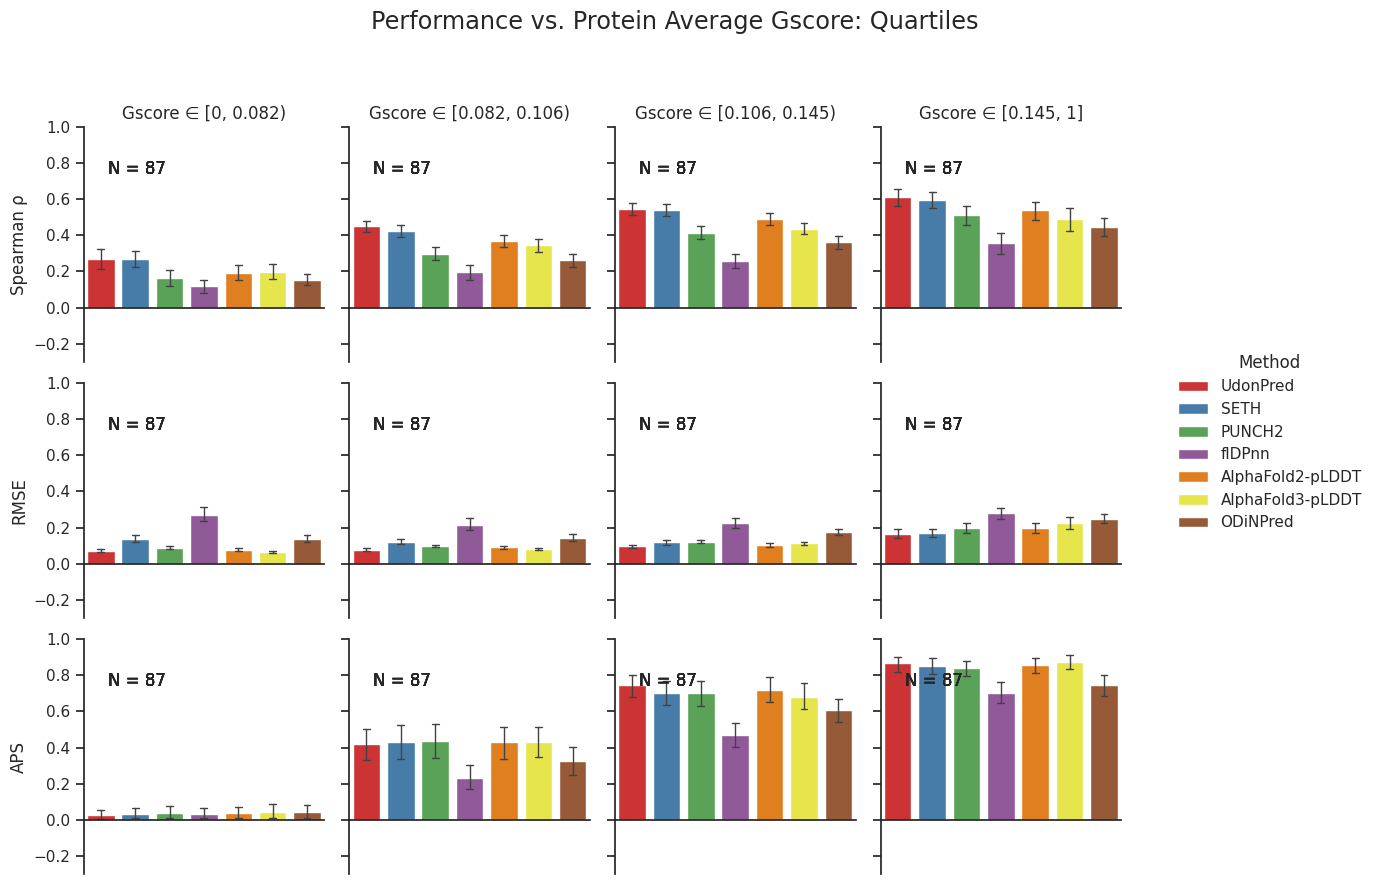

In [11]:
g = sns.FacetGrid(
    protein_df.join(protein_stats, on="ID"),
    col="pscore_mean_quartile",
    col_order=[1, 2, 3, 4],
    row="metric",
    hue="method",
    margin_titles=True
)

g.map(sns.barplot, "method", "value", **BARPLOT_KEYWORDS)

g.set_titles(col_template="{col_name}", row_template="")
g.set_axis_labels("", "Value")
g.set(ylim=(-.3, 1), xticks=[])
g.map_dataframe(annotate_facetplot)

for i, ax in enumerate(g.axes.flat):
    ax.spines["bottom"].set_position("zero")
    if i < 4:
        ax.set_title(f"Gscore ∈ {QUARTILE_LABELS[i]}")

g.axes[0, 0].set_ylabel("Spearman ρ")
g.axes[1, 0].set_ylabel("RMSE")
g.axes[2, 0].set_ylabel("APS")
g.add_legend(title="Method")
plt.suptitle("Performance vs. Protein Average Gscore: Quartiles", fontsize="x-large")
g.figure.subplots_adjust(top=.85)
plt.savefig(PLOT_DIR / "barplot_by_gscore_quartile.png")

### Scatterplot by method

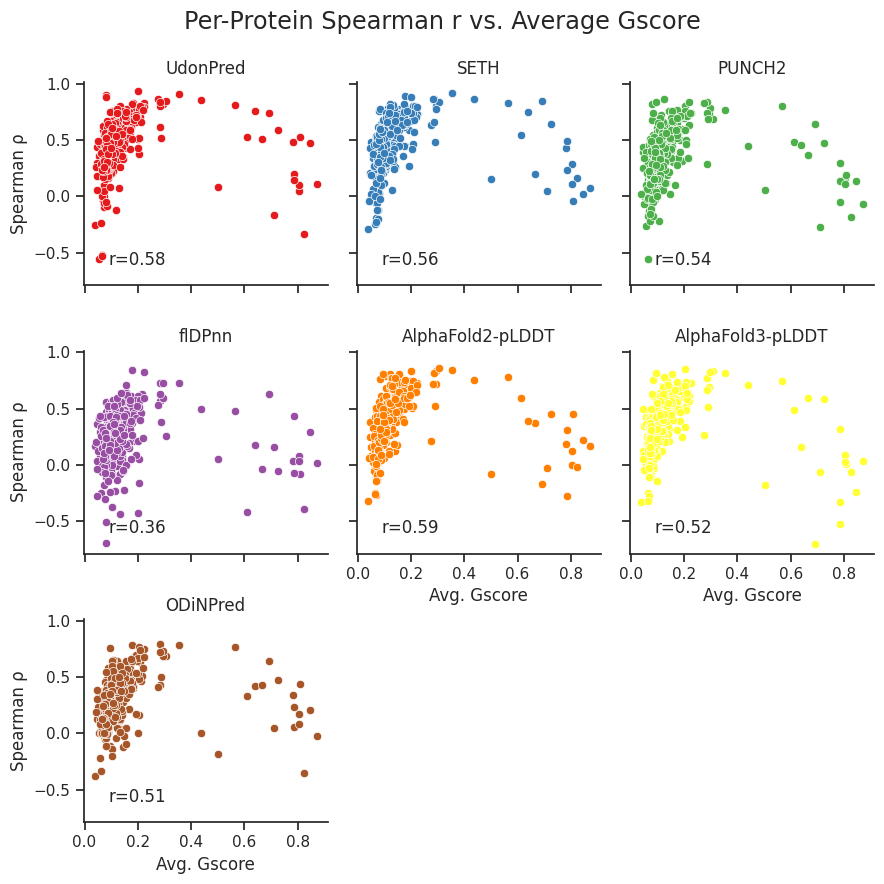

In [4]:
def annotate_facetplot(data, **kws):
    spearman_r = pl.DataFrame(data).select(pl.corr("pscore_mean", "value", method="spearman")).item(0, 0)
    ax = plt.gca()
    ax.text(.1, .1, f"r={spearman_r:.2f}", transform=ax.transAxes)

g = sns.FacetGrid(
    protein_df.join(protein_stats, on="ID").filter(pl.col("metric") == "spearman"),
    col="method",
    col_wrap=3,
    hue="method",
    )

g.map(sns.scatterplot, "pscore_mean", "value")
g.map_dataframe(annotate_facetplot)
plt.suptitle("Per-Protein Spearman r vs. Average Gscore", fontsize="x-large")
g.set_titles(col_template="{col_name}")
g.figure.subplots_adjust(top=.9)
g.set_ylabels("Spearman ρ")
g.set_xlabels("Avg. Gscore")